<a href="https://colab.research.google.com/github/Strongkong/Deep-Learning-HW/blob/master/ksnotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kickstarter project

In [0]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Preparation of data -> this was done offline, result is "test_joined.csv"

### Cleaning the kaggle dataset

Dataset 1: https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv

Dataset 2: https://webrobots.io/kickstarter-datasets/

In [0]:
def cleankaggle():
  data = []
  linecnt = 0
  with open("ks-projects-201801.csv", encoding='latin1') as f:
      for line in f.readlines():
          split_ = line.split(',')
          linecnt += 1
          if linecnt % 10000 == 0:
              print(linecnt)
          if len(split_) == 15:
              data.append(line)

  print("Added {} to output".format(len(data)))
  with open("test_newer.csv", 'w', encoding='latin1') as outf:
      outf.writelines(data)

### Cleaning and joining the webcrawler dataset

In [0]:
def cleanwebcrawler():
  import os
  from csv import reader, writer

  inputfolder = r"G:\Deep Learning"
  csv_filetemplate = "Kickstarter%03d.csv"
  first = True


  def clean_columns(split2):
      max_len = 37
      keep = [1, 16, 29, 30]
      temp = []
      for i in range(0, max_len):
          if i in keep:
              temp.append(split2[i])

      return temp


  for i in range(0, 51):
      linecnt = 0
      data = []
      fname = csv_filetemplate % i if i != 0 else "Kickstarter.csv"
      fname = inputfolder + os.sep + fname
      print("Opening and processing {}".format(fname))
      with open(fname, encoding='latin1') as f:
          csvreader = reader(f)
          for line in csvreader:
              if first:
                  split_ = line
                  print("First line: {}".format(split_))
                  split_ = clean_columns(split_)
                  print("Cleaned first line: {}".format(split_))
                  data.append(split_)
                  first = False
              else:
                  split_ = line
                  linecnt += 1
                  if linecnt % 1000 == 0:
                      print(linecnt)
                      print(len(split_))
                  if len(split_) == 37:
                      split_ = clean_columns(split_)
                      data.append(split_)
      print("Added {} to output from file {}".format(len(data), fname))
      with open("test_dataset2.csv", 'a', encoding='latin1', newline='') as outf:
          csvwriter = writer(outf)
          for row in data:
              csvwriter.writerow(row)

### Joining the two datasets on ID

In [0]:
def joinonids():
  from csv import reader, writer

  with open("test_newer.csv", encoding='latin1') as f:
      with open("test_dataset2.csv", encoding='latin1') as second:
          csvreader1 = reader(f)
          csvreader2 = reader(second)
          cache = dict()
          firstrow = None
          for row in csvreader1:
              if firstrow is None:
                  firstrow = row
              else:
                  cache[row[0]] = row

          print("Done caching IDs from first file.")
          output = list()
          for row in csvreader2:
              if firstrow is not None:
                  key = row.pop(1)
                  row.extend(firstrow)
                  output.append(row)
                  firstrow = None
              else:
                  if row[1] in cache.keys():
                      key = row.pop(1)
                      row.extend(cache[key])
                      del cache[key]
                      output.append(row)

  print("IDs found in test.csv = {}".format(len(cache) + len(output)))
  print("Matching IDs output = {}".format(len(output)))
  print("Writing out...")
  with open("test_joined.csv", 'w', encoding='latin1', newline='') as outf:
      csvwriter = writer(outf)
      for row in output:
          csvwriter.writerow(row)

## Github clone the dataset -> separate from normal github

In [23]:
!git clone https://github.com/Strongkong/cleaned_kickstarted_dataset

fatal: destination path 'cleaned_kickstarted_dataset' already exists and is not an empty directory.


In [0]:
folder = "./cleaned_kickstarted_dataset/"
filename = "test_joined.csv"
fullpath = folder + filename

## Load csv file

In [0]:
df = pd.read_csv(fullpath, encoding='utf-8', sep=',')

## Remove whitespaces from header names

In [0]:
df = df.rename(columns=lambda x: x.strip())


## Get rid of unnecessary columns

In [0]:
# not necessary: spotlight, staff_pick, goal, usd pledged, pledged
df = df[['blurb', 'ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'usd_goal_real', 'launched', 'usd_pledged_real', 'state', 'backers', 'country']]

In [0]:
# print(df.count()['ID'])
# print(df.count()['blurb'])

In [29]:
# df[df.isnull().any(axis=1)]
df = df[df.notnull().all(axis=1)].reset_index(drop=True)
print(len(df))

160307


## Peak at head

In [30]:
print (df.blurb[3])

Für die Finanzierung der Veröffentlichung meiner Masterarbeit, die dann als eigenständiges Buch bei Turia&Kant erscheint.


In [0]:
# df.head()

In [0]:
# df.tail()

## Main categorical features

### Categories

In [0]:
categories = df.category.unique()
# print(categories)

### Main categories

In [0]:
main_categories = df.main_category.unique()
# print(main_categories)

### Currencies

In [0]:
currencies = df.currency.unique()
# print(currencies)

### States

In [0]:
states = df.state.unique()
# print(states)

#### Only keep failed and successful

In [0]:
# df.groupby('state').count()[['ID']]

In [0]:
df = df.loc[(df['state'] == 'failed') | (df['state'] == 'successful')].reset_index(drop=True)

# df.count()['ID']

In [39]:
df.groupby('state').count()[['ID']]

,ID
state,
failed,65918
successful,85646


### Country

In [0]:
countries = df.country.unique()
# print(countries)

## Output scaling

In [0]:
df['usd_goal_real'] = df['usd_goal_real'].apply(lambda x: x/1000, 1)
df['usd_pledged_real'] = df['usd_pledged_real'].apply(lambda x: x/1000, 1)

## Data visualization

### Categorical features

In [0]:
categorical_features = ['category', 'main_category', 'state', 'country', 'currency']
from copy import deepcopy
data = deepcopy(df)
n_items = len(data)

### COMMENTED OUT Only display common ones (source: laboratory 1)

Processing category. Unique count: 159.
['Nonfiction' 'Publishing' 'Mixed Media' 'Web' 'People' 'Comic Books'
 'Comedy' 'Punk' 'Technology' 'Theater' 'Jazz' 'Software' 'Anthologies'
 'Science Fiction' 'Illustration' 'Gadgets' 'Product Design' 'Farms'
 'Workshops' 'Footwear' 'Weaving' 'Sculpture' 'Experimental' 'Pet Fashion'
 'Art' 'Graphic Design' 'Civic Design' 'Tabletop Games' 'Calendars'
 'Design' 'Electronic Music' 'Installations' 'Family' 'Festivals'
 'Conceptual Art' 'Performance Art' 'Glass' 'Painting' 'Plays'
 'Letterpress' 'Public Art' 'Accessories' 'DIY' 'Small Batch'
 'Video Games' 'Music' 'Comics' 'Digital Art' 'Immersive' 'Hardware'
 'Radio & Podcasts' "Children's Books" 'Jewelry' 'Flight' 'Musical' 'Rock'
 'Apparel' 'Nature' 'Games' 'Crafts' 'Robots' 'Stationery' 'Fine Art'
 'DIY Electronics' 'Space Exploration' 'Apps' 'Movie Theaters'
 'Woodworking' 'Printing' 'Knitting' 'Crochet' 'Camera Equipment'
 'Wearables' 'Makerspaces' 'Pottery' 'Photography' 'Fashion' 'Candles'
 

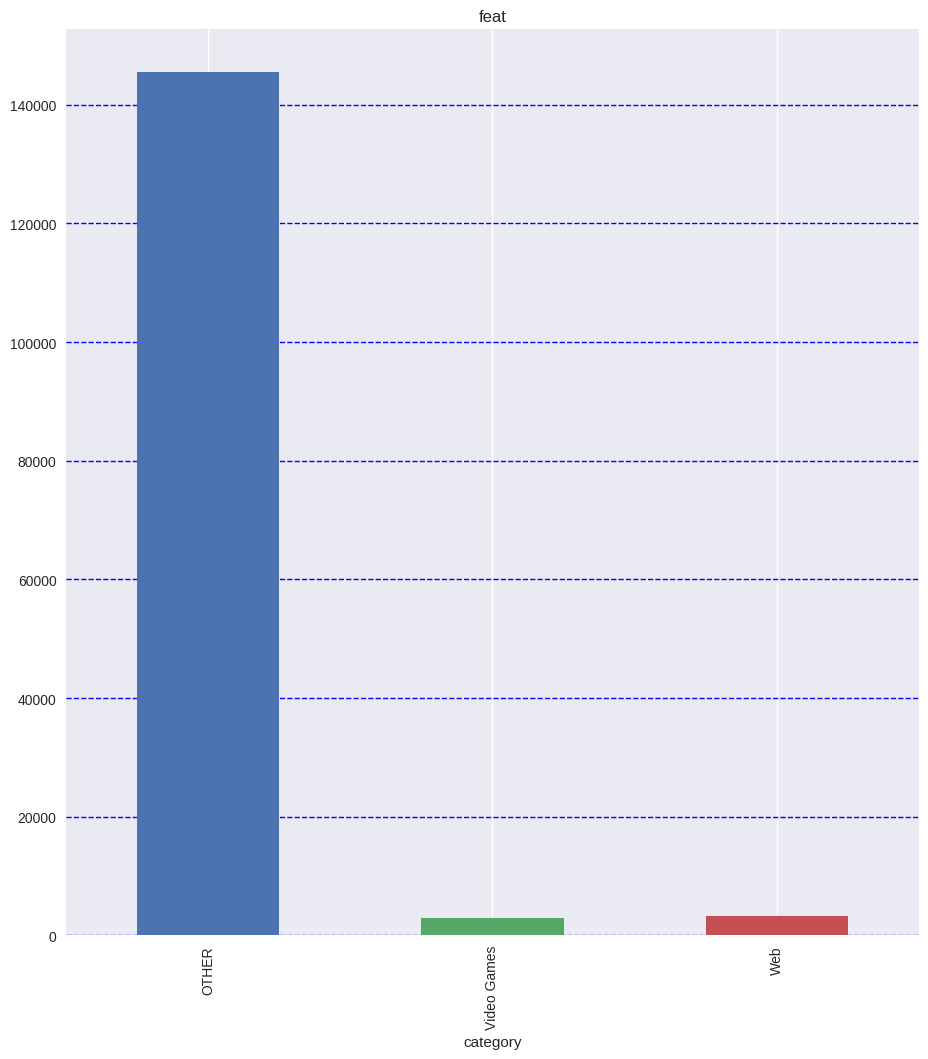

<class 'pandas.core.series.Series'>
Processing main_category. Unique count: 15.
['Publishing' 'Art' 'Journalism' 'Photography' 'Comics' 'Film & Video'
 'Music' 'Technology' 'Theater' 'Design' 'Food' 'Dance' 'Fashion' 'Crafts'
 'Games']


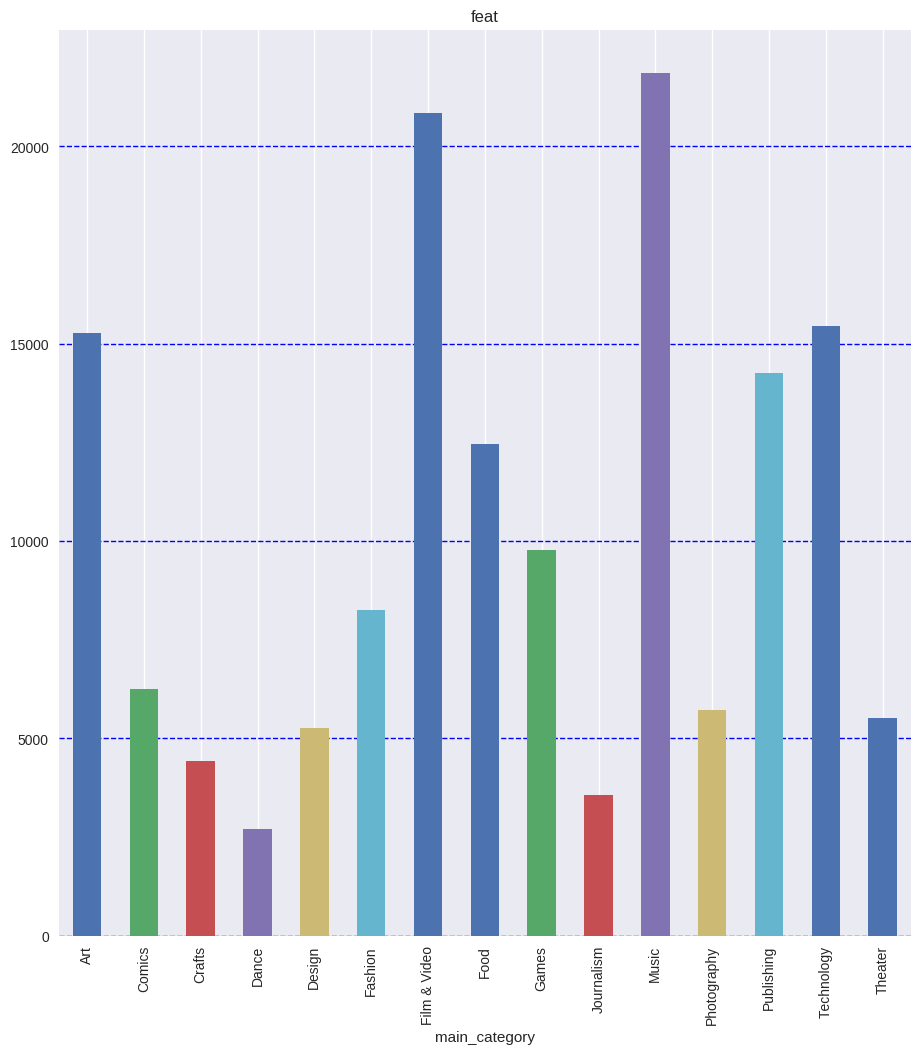

<class 'pandas.core.series.Series'>
Processing state. Unique count: 2.
['successful' 'failed']


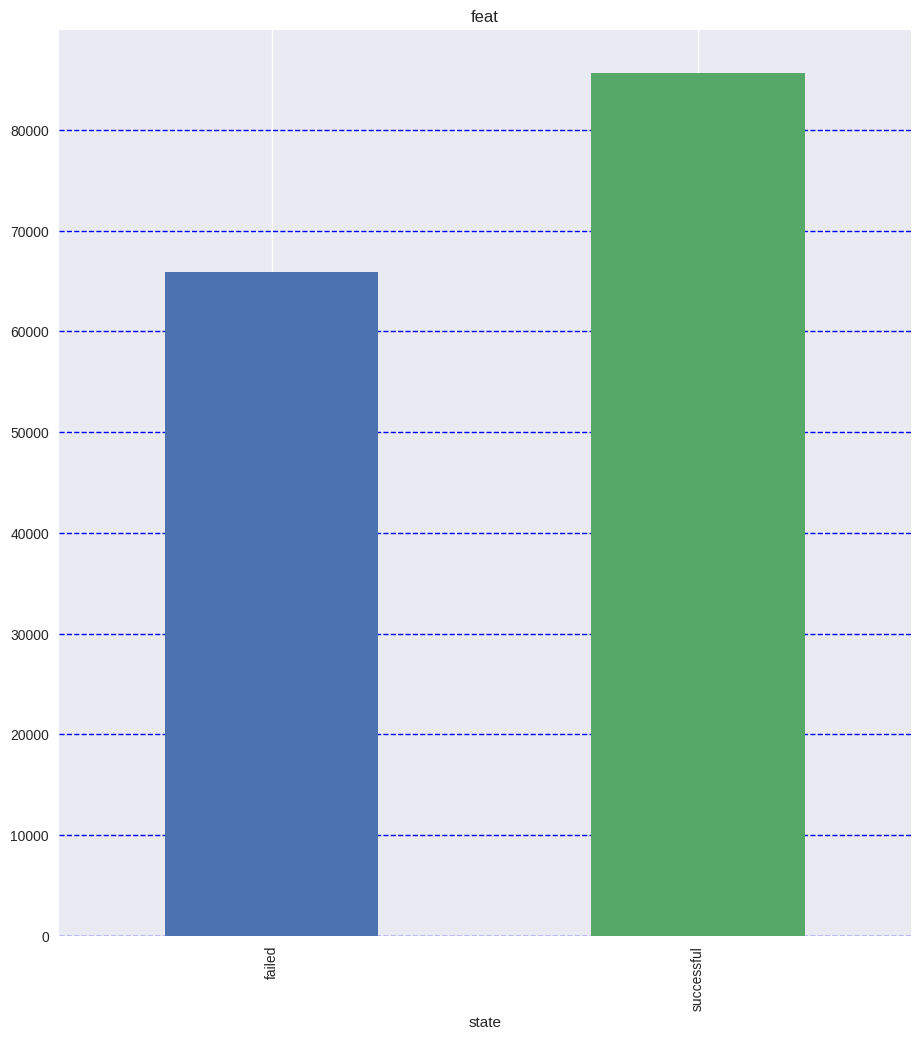

<class 'pandas.core.series.Series'>
Processing country. Unique count: 22.
['US' 'GB' 'CA' 'DE' 'AU' 'BE' 'FR' 'ES' 'NZ' 'SE' 'LU' 'NL' 'NO' 'AT'
 'DK' 'MX' 'IE' 'IT' 'HK' 'SG' 'CH' 'JP']


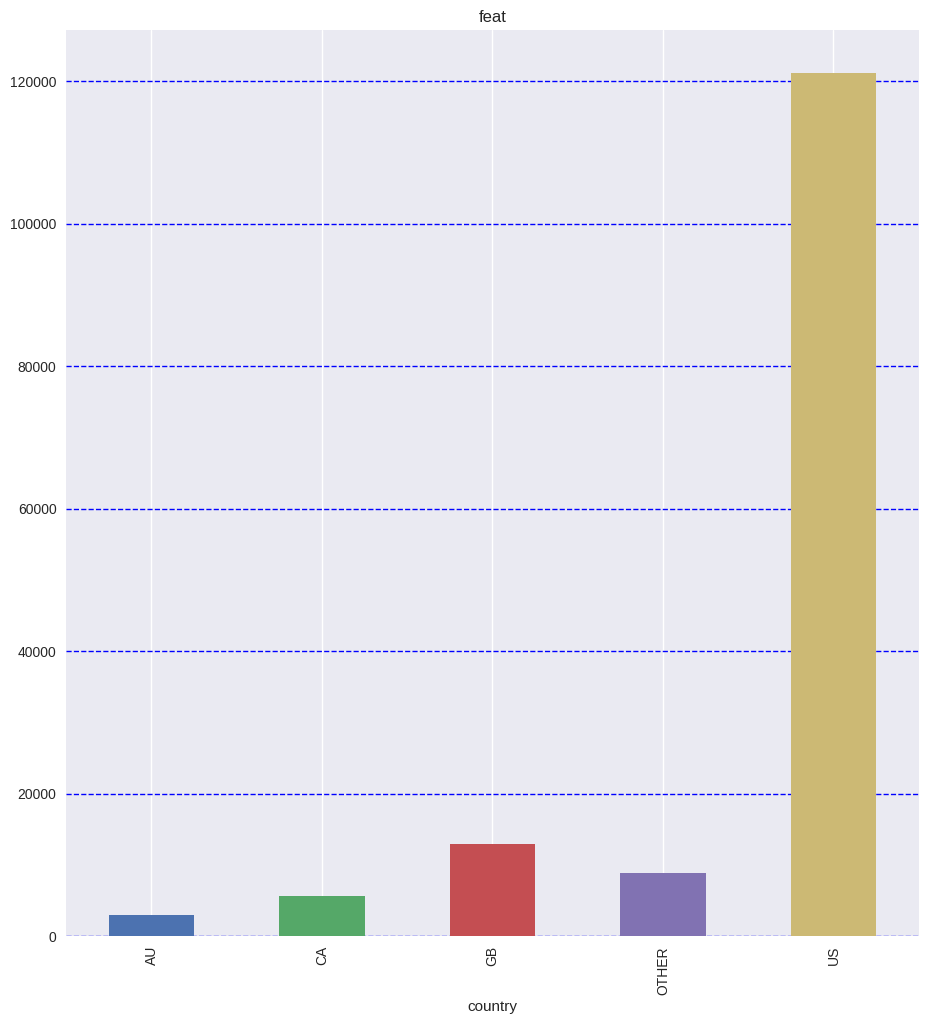

<class 'pandas.core.series.Series'>
Processing currency. Unique count: 14.
['USD' 'GBP' 'CAD' 'EUR' 'AUD' 'NZD' 'SEK' 'NOK' 'DKK' 'MXN' 'HKD' 'SGD'
 'CHF' 'JPY']


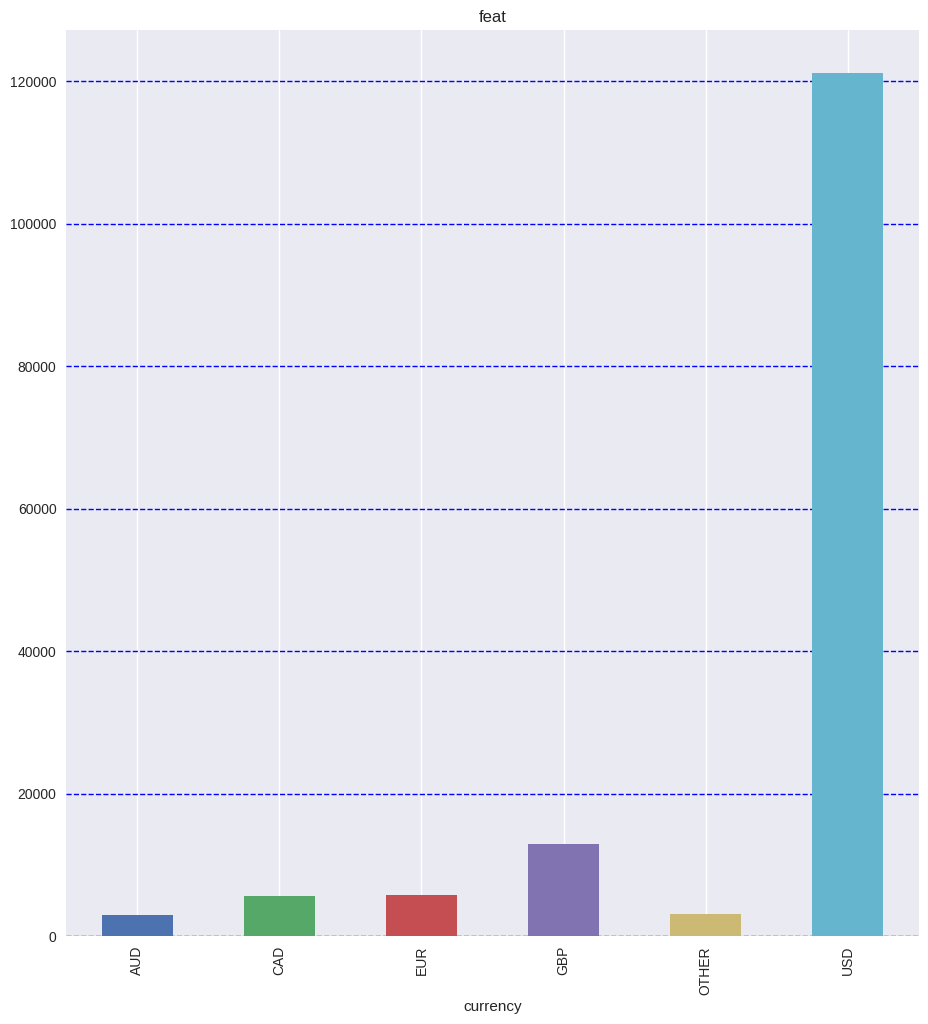

<class 'pandas.core.series.Series'>


In [107]:
index_ = 1

#plt.subplots_adjust(hspace=3.5)
for feat in categorical_features:
  fig = plt.figure(figsize=(11,12), dpi=100)
  ax = fig.add_subplot(1,1,1)
  plt.subplots_adjust(hspace=0.5)
  uniques = data[feat].nunique()
  print("Processing {}. Unique count: {}.".format(feat, uniques))
  if uniques < 160:
    print(data[feat].unique())
    for feat_value in data[feat].unique():
      if (len(data[data[feat]==feat_value])) / n_items < 0.015:
        # print("Adding {} category to OTHER...".format(feat_value))
        data[feat] = data[feat].apply(lambda x: "OTHER" if x==feat_value else x, 1)
  counts = data.groupby(feat).count()
  #plt.subplot(len(categorical_features), 1, index_)
  index_ += 1
  counts.iloc[:,0].plot(kind='bar', ax=ax, figsize=(11,12), title='feat', grid=True)
  plt.grid(b=True, which='major', color='b', linestyle='--', axis='y')
  plt.show()
  print(type(counts.iloc[:,0]))

## Feature Engineering

In [44]:
df.state.unique()

array(['successful', 'failed'], dtype=object)

In [45]:
df.tail()

,blurb,ID,name,category,main_category,currency,deadline,usd_goal_real,launched,usd_pledged_real,state,backers,country
151559,A full-color book of my best robot themed sket...,1219087950,Mecha Zone Robot Sketches,Art Books,Publishing,USD,2016-11-03,1.00000,2016-10-03 13:19:32,3.83800,successful,100,US
151560,[Kickstarter Gold] A culinary love story with ...,1161973724,The Lotus and the Artichoke - INDIA vegan cook...,Vegan,Food,EUR,2017-08-03,11.86803,2017-07-04 14:36:49,37.21221,successful,1165,DE
151561,Creating a tourism promotional calendar of the...,362841351,Best of the 1000 Islands,Places,Photography,CAD,2014-07-27,0.22881,2014-06-27 01:59:06,0.06407,failed,4,CA
151562,Jesus has saved my life so I am creating this ...,672477562,St. Christopher - God Is Great,Faith,Music,USD,2015-01-11,1.00000,2014-11-12 18:43:56,0.00100,failed,1,US
151563,"""Bash"" is an action drama web series about a b...",782376245,Bash,Webseries,Film & Video,USD,2013-11-01,2.00000,2013-10-11 01:27:57,2.11000,successful,27,US


### Encode labels -> has to be changed to OneHotEncoder

In [46]:
!pip install -U scikit-learn

    100% |████████████████████████████████| 5.3MB 1.2MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [48]:
categories_le = LabelEncoder()
categories_ohe = OneHotEncoder(sparse=False) # readable for humans

categories_led = categories_le.fit_transform(df.category)
categories_led = categories_led.reshape(-1, 1)

df_category = pd.DataFrame(categories_ohe.fit_transform(categories_led))
df_category = df_category.rename(columns=lambda x: 'category_' + str(x))
df = df.join(df_category)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [49]:
maincategories_le = LabelEncoder()
maincategories_ohe = OneHotEncoder(sparse=False) # readable for humans

maincategories_led = maincategories_le.fit_transform(df.main_category)
maincategories_led = maincategories_led.reshape(-1, 1)

df_main_category = pd.DataFrame(maincategories_ohe.fit_transform(maincategories_led))
df_main_category = df_main_category.rename(columns=lambda x: 'maincategory_' + str(x))
df = df.join(df_main_category)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [50]:
state_le = LabelEncoder()
state_ohe = OneHotEncoder(sparse=False) # readable for humans

state_led = state_le.fit_transform(df.state)
state_led = state_led.reshape(-1, 1)

df_state = pd.DataFrame(state_ohe.fit_transform(state_led))
df_state = df_state.rename(columns=lambda x: 'state_' + str(x))
df = df.join(df_state)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [51]:
country_le = LabelEncoder()
country_ohe = OneHotEncoder(sparse=False) # readable for humans

country_led = country_le.fit_transform(df.country)
country_led = country_led.reshape(-1, 1)

df_country = pd.DataFrame(country_ohe.fit_transform(country_led))
df_country = df_country.rename(columns=lambda x: 'country_' + str(x))
df = df.join(df_country)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [52]:
currency_le = LabelEncoder()
currency_ohe = OneHotEncoder(sparse=False) # readable for humans

currency_led = currency_le.fit_transform(df.currency)
currency_led = currency_led.reshape(-1, 1)

df_currency = pd.DataFrame(currency_ohe.fit_transform(currency_led))
df_currency = df_currency.rename(columns=lambda x: 'currency_' + str(x))
df = df.join(df_currency, rsuffix='_curr')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


categories_le = LabelEncoder()
df.category = categories_le.fit_transform(df.category)


maincategories_le = LabelEncoder()
df.main_category = maincategories_le.fit_transform(df.main_category)


state_le = LabelEncoder()
df.state = state_le.fit_transform(df.state)


country_le = LabelEncoder()
df.country = country_le.fit_transform(df.country)


currency_le = LabelEncoder()
df.currency = currency_le.fit_transform(df.currency)


### Change spotlight and staff pick to numeric values

In [0]:
#df.spotlight = df.spotlight.astype(int)
#df.staff_pick = df.staff_pick.astype(int)

### Drop ID, we dont need it anymore

In [0]:
df = df.drop('ID', axis=1)

In [0]:
# df.head()

### Calculate length of funding

In [0]:
diff = (pd.to_datetime(df.deadline) - pd.to_datetime(df.launched)).map(lambda x: x.days)


In [0]:
# print(diff.head())

In [0]:
# diff.shape

### Drop date times

In [0]:
df = df.drop(['deadline', 'launched'], axis=1)


In [0]:
# df.shape

### Add duration to the dataframe

In [0]:
df['duration'] = diff

In [0]:
# df.shape

In [0]:
# df.head()

### Clean text, only keep whitespaces and letters

In [0]:
import re

In [0]:
regex = re.compile(r"[^\w\d ]", re.UNICODE | re.IGNORECASE)

name = df.name
blurb = df.blurb

name = name.map(lambda x: regex.sub(' ', str(x)).lower())
blurb = blurb.map(lambda x: regex.sub(' ', str(x)).lower())

# print("names:")
# print(name.head())
# print("\nblurbs:")
# print(blurb.head())

In [0]:
name2 = name.apply(lambda x: x.split())
blurb2 = blurb.apply(lambda x: x.split())

# print("names:")
# print(name2.head())
# print("\nblurbs:")
# print(blurb2.head())

### Remove stop words -> might give better results

In [67]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words = set(stopwords.words('english'))

In [0]:
name2 = name2.apply(lambda lista: [szo for szo in lista if szo not in stop_words] )
blurb2 = blurb2.apply(lambda lista: [szo for szo in lista if szo not in stop_words] )

# print("names:")
# print(name2.head(10))
# print("\nblurbs:")
# print(blurb2.head(10))

### Create bag of words
Using HashingVectorizer, because there are a lot of words

In [0]:
from sklearn.feature_extraction.text import HashingVectorizer

In [0]:
name_vectorizer = HashingVectorizer(n_features=2**8, lowercase=False, tokenizer = lambda doc: doc)
blurb_vectorizer = HashingVectorizer(n_features=2**8, lowercase=False, tokenizer = lambda doc: doc)

hashed_name = name_vectorizer.transform(name2)
hashed_blurb = blurb_vectorizer.transform(blurb2)

# print("names:")
# print(hashed_name.shape)
# print(hashed_name[0])
# print("\nblurbs:")
# print(hashed_blurb.shape)
# print(hashed_blurb[0])

In [0]:
# print("names:")
# print(hashed_name[0])
# print("\nblurbs:")
# print(hashed_blurb[0])

In [0]:
# print(type(hashed_name))
# print(type(hashed_blurb))

In [0]:
# print(hashed_name.todense().shape)
# print(hashed_blurb.todense().shape)

### Create dataframe from scipy sparse matrix

In [0]:
df_hashed_name = pd.DataFrame(hashed_name.todense())
df_hashed_name = df_hashed_name.rename(columns=lambda x: 'name_' + str(x))
df_hashed_blurb = pd.DataFrame(hashed_blurb.todense())
df_hashed_blurb = df_hashed_blurb.rename(columns=lambda x: "blurb_" + str(x))

# print("names:")
# print(df_hashed_name.head())
# print("\nblurbs:")
# print(df_hashed_blurb.head())

### Concat original matrix and hashed name matrix

In [0]:
df = df.join(df_hashed_name)
df = df.join(df_hashed_blurb)

In [0]:
# print(df.shape)

### Dropping name column, name is stored now in bag

In [0]:
drop_columns = ['category', 'main_category', 'state', 'country', 'currency', 'name', 'blurb']

df = df.drop(drop_columns, axis=1)

In [0]:
# df.head()

### Split into input and output

In [80]:
state_columns = df.columns[df.columns.str.startswith('state_')].values.tolist()
print('state columns are', state_columns)
output_columns = ['backers', 'usd_pledged_real'] + state_columns
#print("Output columns are", output_columns)

# Currently using state_columns for testing
X = df.drop(output_columns, axis=1)
Y = df[df.columns.intersection(state_columns)]
#Y = df['usd_pledged_real']

state columns are ['state_0', 'state_1']


## Preparation for teaching

### Imports

In [81]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import copy
import pandas as pd
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(123)
np.random.seed(123)

Using TensorFlow backend.


In [0]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

### Splitting into train test valid

In [83]:
test_split = 0.1
valid_split = 0.2

v_index = int(X.shape[0] * (1-valid_split-test_split))
t_index = int(X.shape[0] * (1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]

X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X_train = X[:v_index]
Y_train = Y[:v_index]

scaler = StandardScaler().fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [84]:
X.tail()

,usd_goal_real,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,...,blurb_246,blurb_247,blurb_248,blurb_249,blurb_250,blurb_251,blurb_252,blurb_253,blurb_254,blurb_255
151559,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151560,11.86803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151561,0.22881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151562,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151563,2.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
Y.tail()

,state_0,state_1
151559,0.0,1.0
151560,0.0,1.0
151561,1.0,0.0
151562,1.0,0.0
151563,0.0,1.0


### Creating model

In [87]:
es = EarlyStopping(monitor='val_loss' ,patience=10, min_delta = 0.0001)
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

print("X Shape is ", X_train.shape[1], "Y Shape is", Y_train.shape[1]) #Y_train.shape[1]

# TODO: use regularization and dropout to prevent overfitting
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), use_bias=True, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(256, use_bias=True, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(Y_train.shape[1], activation='sigmoid')) #Y_train.shape[1]

sgd = SGD(lr=1e-3, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)

history = model.fit(X_train, Y_train, epochs=100000, batch_size=128,
                    verbose=2, validation_data=(X_valid,Y_valid),
                   callbacks=[mcp, es])

X Shape is  724 Y Shape is 2
Train on 106094 samples, validate on 30313 samples
Epoch 1/100000
 - 9s - loss: 0.2538 - val_loss: 0.2283

Epoch 00001: val_loss improved from inf to 0.22833, saving model to weights.hdf5
Epoch 2/100000
 - 9s - loss: 0.2164 - val_loss: 0.2031

Epoch 00002: val_loss improved from 0.22833 to 0.20310, saving model to weights.hdf5
Epoch 3/100000
 - 9s - loss: 0.1947 - val_loss: 0.1862

Epoch 00003: val_loss improved from 0.20310 to 0.18617, saving model to weights.hdf5
Epoch 4/100000
 - 9s - loss: 0.1821 - val_loss: 0.1769

Epoch 00004: val_loss improved from 0.18617 to 0.17692, saving model to weights.hdf5
Epoch 5/100000
 - 9s - loss: 0.1738 - val_loss: 0.1707

Epoch 00005: val_loss improved from 0.17692 to 0.17072, saving model to weights.hdf5
Epoch 6/100000
 - 9s - loss: 0.1682 - val_loss: 0.1675

Epoch 00006: val_loss improved from 0.17072 to 0.16752, saving model to weights.hdf5
Epoch 7/100000
 - 10s - loss: 0.1649 - val_loss: 0.1652

Epoch 00007: val_loss

### Loading the best checkpoint

In [0]:
from keras.models import load_model

model = load_model('weights.hdf5')

### Calculating mean absolute error

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
preds = model.predict(X_test)
err = mean_absolute_error(Y_test, preds)

print("Error on test data: {}".format(err))

Error on test data: 0.30350642641422143


In [90]:
print(preds[0][:4])
print(type(preds))
print(type(Y_test))

[0.42539573 0.57918626]
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [91]:
print(preds.shape)
print(Y_test.shape)

(15157, 2)
(15157, 2)


### Creating DataFrame from the predictions

In [0]:
pred_df = pd.DataFrame(data=preds)

In [93]:
pred_df.head()

,0,1
0,0.425396,0.579186
1,0.163989,0.835533
2,0.839773,0.153521
3,0.748546,0.254451
4,0.011945,0.987800


In [94]:
Y_test.head()

,state_0,state_1
136407,1.0,0.0
136408,1.0,0.0
136409,1.0,0.0
136410,0.0,1.0
136411,0.0,1.0


### Inverse transforming the one hot encoding to states

In [0]:
Y_test_state = state_ohe.inverse_transform(Y_test)

In [96]:
Y_test_state[-5:]

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.]])

In [97]:
type(Y_test_state)

numpy.ndarray

### Inverse transforming the label encoded values back to state names

In [98]:
Y_test_state2 = state_le.inverse_transform(Y_test_state.astype(int))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
Y_test_state2[:5]

array(['failed', 'failed', 'failed', 'successful', 'successful'],
      dtype=object)

### Finding the column id of the maximum value (e.g. the one that the network predicted to be the highest 'chance')

In [0]:
pred_test = pred_df.idxmax(axis=1)

### Transforming back the number to the label
This here is using the fact that the encodings are onehotencoded, and it is the same number as the column number

In [0]:
pred_inverted = state_le.inverse_transform(pred_test)

In [102]:
state_le.classes_

array(['failed', 'successful'], dtype=object)

In [103]:
pred_inverted

array(['successful', 'successful', 'failed', ..., 'failed', 'failed',
       'successful'], dtype=object)

In [104]:
pred_inverted.shape

(15157,)

In [105]:
Y_test_state2.shape

(15157,)

### Getting a sample of the predictions
Currently the network isn't as accurate as we would like it to be, we hope that in the future we can improve the accuracy

In [106]:
print("First 10")
for i in range(10):
  print("Predicted ", pred_inverted[i], " |||| was:", Y_test_state2[i])

First 10
Predicted  successful  |||| was: failed
Predicted  successful  |||| was: failed
Predicted  failed  |||| was: failed
Predicted  failed  |||| was: successful
Predicted  successful  |||| was: successful
Predicted  successful  |||| was: failed
Predicted  failed  |||| was: failed
Predicted  failed  |||| was: failed
Predicted  failed  |||| was: successful
Predicted  failed  |||| was: successful
